# Analyze Clusters

In the first part of this notebook the main characteristics (mean feature values) of the 12 segments are analyzed and documented. In the second part the demogaphic features of customers of different segments are compared in an attempt to find demographic groups that respond differently to BOGOs vs. discounts.

### Data Sources

Profile type data with clusters appended, as prepared in notebook 4: `profile_type_w_clusters.csv`

### Changes

- 2019-01-29: Started notebook
- 2019-01-31: Add block on demographics
- 2019-02-04: Add block on info offers, finish notebook


In [18]:
# load libraries

import numpy as np
import pandas as pd
from tqdm import tqdm

# my own custom functions
import EDA_functions as EDA
import cleaning_functions as cleaning

# visualization
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('white')
color = 'rebeccapurple'
%matplotlib inline

# display settings
from IPython.display import display
pd.options.display.max_columns = None

from pathlib import Path  # to make file path references relative to notebook directory

In [19]:
# import preparated data

profile_clusters_file = Path.cwd() / "data" / "processed" / "profile_type_w_clusters.csv"
profile_clusters = pd.read_csv(profile_clusters_file, index_col = 0, dtype={'gender' : 'category'})

In [20]:
display(profile_clusters.head())
display(profile_clusters.info())

,age,gender,income,member_days,offer_received,offer_viewed,offer_completed,viewed_received,completed_viewed,total_trans,total_amount,total_reward,total_profit,prop_reward,total_mean_amount,np_trans,np_amount,np_mean_amount,prop_np_trans,prop_np_amount,bogo_completed,bogo_viewed,bogo_trans,bogo_amount,discount_completed,discount_viewed,discount_trans,discount_amount,info_viewed,info_trans,info_amount,prop_bogo_amount,prop_discount_amount,prop_info_amount,bogo_vtc,discount_vtc,prop_bogo_viewed,prop_discount_viewed,prop_info_viewed,prop_by_accident,view_to_complete,cluster
p_1,NaN,NaN,NaN,-529,5.0,5.0,2.0,1.00,2.0,9.0,20.40,5.0,15.40,0.245098,2.266667,0,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000,2.0,5.0,9.0,20.400,0.0,0.0,0.000,0.000000,1.000000,0.000000,0.0,0.4,0.000000,1.000000,0.000000,0.00,0.4,4.0
p_10,NaN,NaN,NaN,-611,4.0,3.0,1.0,0.75,0.0,6.0,15.62,5.0,10.62,0.320102,2.603333,3,7.69,2.563333,0.500000,0.492318,0.0,2.0,3.0,7.930,0.0,0.0,0.0,0.000,1.0,0.0,0.000,0.507682,0.000000,0.000000,0.0,0.0,0.666667,0.000000,0.333333,0.25,0.0,11.0
p_100,68.0,F,84000.0,-725,5.0,0.0,1.0,0.00,0.0,2.0,34.04,2.0,32.04,0.058754,17.020000,2,34.04,17.020000,1.000000,1.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.20,0.0,7.0
p_1000,67.0,M,44000.0,-225,4.0,4.0,0.0,1.00,0.0,5.0,19.78,0.0,19.78,0.000000,3.956000,2,13.37,6.685000,0.400000,0.675935,0.0,3.0,3.0,5.555,0.0,0.0,0.0,0.000,1.0,1.0,0.855,0.280839,0.000000,0.043225,0.0,0.0,0.750000,0.000000,0.250000,0.00,0.0,11.0
p_10000,NaN,NaN,NaN,-446,3.0,3.0,0.0,1.00,0.0,6.0,7.28,0.0,7.28,0.000000,1.213333,1,1.83,1.830000,0.166667,0.251374,0.0,2.0,4.0,3.935,0.0,1.0,3.0,1.515,0.0,0.0,0.000,0.540522,0.208104,0.000000,0.0,0.0,0.666667,0.333333,0.000000,0.00,0.0,10.0


<class 'pandas.core.frame.DataFrame'>
Index: 17000 entries, p_1 to p_9999
Data columns (total 42 columns):
age                     14825 non-null float64
gender                  14825 non-null category
income                  14825 non-null float64
member_days             17000 non-null int64
offer_received          17000 non-null float64
offer_viewed            17000 non-null float64
offer_completed         17000 non-null float64
viewed_received         17000 non-null float64
completed_viewed        17000 non-null float64
total_trans             17000 non-null float64
total_amount            17000 non-null float64
total_reward            17000 non-null float64
total_profit            17000 non-null float64
prop_reward             17000 non-null float64
total_mean_amount       17000 non-null float64
np_trans                17000 non-null int64
np_amount               17000 non-null float64
np_mean_amount          17000 non-null float64
prop_np_trans           17000 non-null float64
pro

None

## Aggregate and Analyze Cluster Manifestations

In [21]:
"""create aggregated dataframe with mean values, overall and per cluster"""

# re-arange cols for better analysis
cols = ['age', 'gender', 'income', 'member_days', 'offer_received',
        'offer_viewed', 'viewed_received', 'prop_bogo_viewed', 'prop_discount_viewed', 
        'prop_info_viewed', 'offer_completed', 'completed_viewed', 'view_to_complete', 
        'prop_by_accident', 'total_trans', 'total_amount', 'total_reward', 
        'total_profit', 'prop_reward', 'total_mean_amount', 'np_trans',
        'np_amount', 'np_mean_amount', 'prop_np_trans', 'prop_np_amount',
        'prop_bogo_amount', 'prop_discount_amount', 'prop_info_amount', 
        'bogo_vtc', 'discount_vtc', 'bogo_completed', 'bogo_viewed', 
        'bogo_trans', 'bogo_amount', 'discount_completed', 'discount_viewed', 
        'discount_trans', 'discount_amount', 'info_viewed', 'info_trans', 
        'info_amount', 'cluster']

assert len(cols) == len(profile_clusters.columns)  # safety-check
profile_clusters = profile_clusters.reindex(columns=cols)

# drop cols that do not help during analysis (iteratively)
profile_clusters.drop(['completed_viewed', 'np_trans', 
                      'np_amount', 'np_mean_amount',
                      'prop_np_trans'], axis=1, inplace=True)

profile_grouped = profile_clusters.groupby(['cluster'])
clusters_mean = pd.DataFrame(profile_grouped.mean())

# add a first row with overall mean values
overall_mean = pd.DataFrame(profile_clusters.mean()).T.set_index('cluster')
clusters_mean = pd.concat([overall_mean, clusters_mean], axis=0)

# some index cosmetics - cluster 0 stands for overall mean values
clusters_mean.reset_index(inplace=True)
clusters_mean['cluster'] = list(range(0,13,1))
clusters_mean.set_index('cluster', inplace=True)

# check results
display(clusters_mean)

,age,income,member_days,offer_received,offer_viewed,viewed_received,prop_bogo_viewed,prop_discount_viewed,prop_info_viewed,offer_completed,view_to_complete,prop_by_accident,total_trans,total_amount,total_reward,total_profit,prop_reward,total_mean_amount,prop_np_amount,prop_bogo_amount,prop_discount_amount,prop_info_amount,bogo_vtc,discount_vtc,bogo_completed,bogo_viewed,bogo_trans,bogo_amount,discount_completed,discount_viewed,discount_trans,discount_amount,info_viewed,info_trans,info_amount
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,54.393524,65404.991568,-517.449882,4.486882,3.395588,0.760115,0.436760,0.362423,0.163990,1.975235,0.478131,0.133522,8.173706,104.438351,9.561882,94.876469,0.101974,13.340673,0.491477,0.213431,0.209033,0.061236,0.347604,0.433754,0.636588,1.482706,1.933765,18.998093,0.730294,1.256588,1.769412,19.467890,0.575412,0.572529,6.882315
1,56.596161,70713.670192,-614.695253,4.641271,3.818913,0.833053,0.514893,0.462615,0.008799,3.813170,0.817592,0.172333,10.475115,182.597749,19.290199,163.307550,0.144528,19.383859,0.523587,0.242095,0.233876,0.000441,0.815493,0.884992,1.498469,1.970138,2.433002,40.151155,1.475498,1.752680,2.400842,38.089978,0.042496,0.009571,0.094766
2,51.937644,58655.889145,-338.998445,4.362364,3.133748,0.732919,0.087610,0.530767,0.345905,0.353033,0.003370,0.079964,4.992224,36.059565,1.390358,34.669207,0.027624,7.867543,0.547322,0.002446,0.327245,0.122987,0.000000,0.006998,0.000000,0.356143,0.063764,0.038103,0.007776,1.561431,1.852255,7.489487,1.115086,0.819596,5.188103
3,54.833792,69915.518825,-599.329806,4.165785,2.705467,0.666299,0.923912,0.004233,0.026749,2.649030,0.736258,0.216652,8.708113,136.752593,17.756614,118.995979,0.182419,17.973431,0.584470,0.413503,0.000000,0.002027,0.739345,0.000000,1.705467,2.463845,3.369489,48.577368,0.000000,0.019400,0.000000,0.000000,0.100529,0.040564,0.485004
4,55.791710,68765.803109,-584.384241,4.086576,2.596304,0.647925,0.021255,0.903356,0.025292,2.535992,0.792445,0.188343,8.731518,126.905661,7.860895,119.044767,0.099226,16.580487,0.543430,0.000087,0.452772,0.003712,0.000000,0.813667,0.000000,0.089494,0.008755,0.008750,1.731518,2.269455,3.422179,50.681503,0.105058,0.055447,0.626712
5,54.636010,67433.937824,-501.391153,4.668219,3.785797,0.819461,0.553764,0.337718,0.089309,2.488941,0.429589,0.234497,8.543655,126.747206,14.350407,112.396799,0.183221,16.814621,0.450071,0.373804,0.148416,0.027709,0.703066,0.047148,1.345751,2.110594,2.818393,38.849942,0.047730,1.211874,1.869616,19.308120,0.387660,0.385332,4.415990
6,53.426000,62488.000000,-534.027284,4.361210,3.058719,0.710647,0.716963,0.022272,0.231089,1.361210,0.433768,0.115589,7.733689,86.305237,8.890866,77.414371,0.103519,11.587032,0.487752,0.410028,0.000077,0.102143,0.453203,0.000000,0.848161,2.069395,3.051008,24.212619,0.000000,0.092527,0.006524,0.003206,0.806050,0.937129,13.549792
7,55.266556,64241.721854,-439.848189,3.736769,1.919220,0.508426,0.130710,0.051300,0.511746,0.473538,0.000000,0.132660,4.811978,57.230557,2.189415,55.041142,0.036529,13.057516,0.814009,0.004850,0.001150,0.179991,0.000000,0.000000,0.000000,0.431755,0.062674,0.074436,0.000000,0.203343,0.036212,0.034666,1.104457,1.011142,11.326706
8,53.959817,65776.255708,-522.378862,4.325203,3.248780,0.762168,0.036301,0.603266,0.334675,1.666667,0.641978,0.110407,7.875610,99.960764,5.071545,94.889220,0.068601,13.770611,0.479425,0.000355,0.389439,0.130781,0.000000,0.682222,0.000000,0.154472,0.021138,0.015675,1.175610,1.875610,2.694309,26.620226,1.130894,1.264228,16.862221


**Findings:**

Biggest segements, both with same amount bogo and disc - differ mainly in bogo acceptance

- Seg 1 (n=2612 / 15.4%): high viewrate (in both largest segments btw), bogo == disc / no info, 0.8 vtc, most profitable / highest spending, rel. high prop reward, np slight above avg, discount vtc 0.9 / bogo vtc 0.8 --> ALL GOOD

- Seg 9 (n=2375 / 14.0%): high received, high viewrate, 0.5 vtc, high profit, low prop_np / acc, bogo == disc, some info, spent higher on discount (trans ==), completed more discount discount vtc 0.9 / bogo vtc 0.6 --> DROP IN BOGO vs. DISC

- Seg 12 (n=1435 / 8.4%): high vr, 35b / 50d / 15i, below avg vtc, below avg spenders, lowest np_amount, high prop d amount, bogo vtc <1!!, discount vtc 0.8, DO NOT LIKE BOGOS at all!

- Seg 5 (n=859 / 5.7%) 50 bogo / 30 disc / 10 info, high vr, mediocre vtc, highest by accident (trotz high vr ...), bigger spenders, bogo vtc 0.7, discount vtc 0.05 (!) - DONT SEEM TO LIKE DISCOUNTS AT ALL

Smallest segments, both with similar high amount info / disc - low spenders

- Seg 7 (n=718 / 4.2%): 15b / 5d / 50i, low offer received, lowest viewrate by far, FEWEST transactions BUT MEAN SPENDING is AVG, no completions of viewed offers (only by accident), 50% of offers were info, prop info amount 17%, is high, but generally they are low in amount --> INFO ALONE DOES NOT HELP --> treat better

Two midsize segments, one bogo only, one disc only - shows that disc performs a little better and profitability is higher!

- Seg 3 (n=1134 / 6.7%) BOGO only, rather low vr, , good overall, vtc 0.7 (same as bogo vtc), high by acc, highest reward share, big spenders, high np-share, --> no promo hunters, but bogo works quite well

- Seg 4 (n=1028 / 6.0%) DISC only low received, low vr (seem correlated), vtc 0.8 (overall, disc), spend (only) a little less than Seg 3 but more profitable due to lower rewards, also above avg np prop --> no promo hunters, but discount works quite well

- Seg 6 (n=1687 / 9.9%): BOGO high and some info (no disc), vr below avg, vtc low (0.4 - all bogo), also no big reaction on info, mediocre spenders, but not as low as other groups - BOGO NOT SO GOOD, maybe potential for discounts?

- Seg 8 (n=1230 / 7.2%): 2/3 disc 1/3 info (higest info rate of all), avg vtr rate, vtc mediocre for disc (0.68), info does have an effect, but its generally small compared to other offers (13% prop amount), avg spenders - DISC OK



LOW PROFIT, NO EFFECT

- Seg 11 (n=961 / 5.7%): 2/3 bogo 1/3 info, lower vtr rate, lowest vtc rate of all!!!, low spenders (a little higher than seg 2), high prop np amount, spend a little during bogo but low, do not complete --> LOW PROFIT; BOGO NO EFFECT

- Seg 2 (n=643 / 3.8%): 10b / 50d/ 40i , vtc near zero, don't react on discount, very low spending, seem to spend under discount but not enough to complete --> LOW, DISCOUNT AND INFO NO EFFECT 

- Seg 10 (n=1471 / 8.7%): 50b / 40d / 10i, good vtr, vtc 1%!!!, very low spenders, small transactions, also lowest np_amount, but not sure if offers have to do with that, maybe minimal effect - anyway they don't cost much ... LOW PROFIT, OFFERS NO EFFECT






Genral findings

- viewrate correlated with number of offers received, inter-segment diff not too big probably 
- info does have an effect, but its generally small compared to other offers (has a notable neg correlation to total profit), 
    - but also a positive correlation to prop np amount (but that doesnt help)
    - info seems to be shown to younger / older members? notable correlation to member_days)


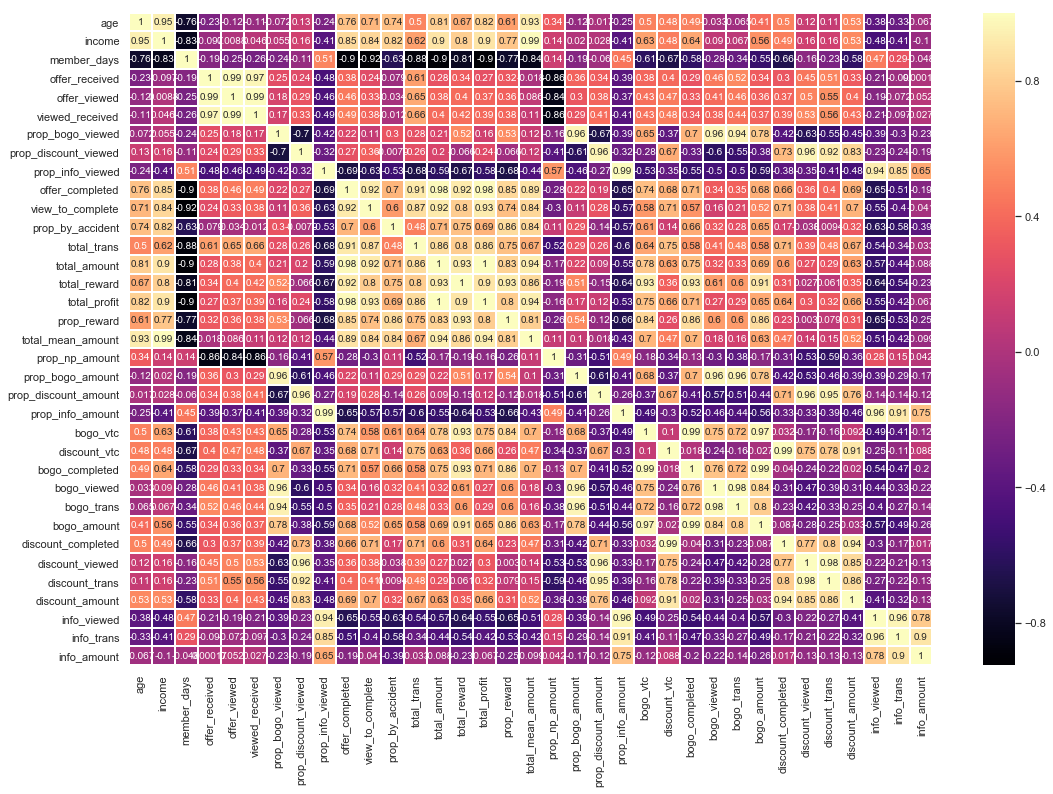

In [23]:
"""show correlations between features"""

EDA.plot_num_corrMap(clusters_mean, figsize=(18, 12))

## Visualize effects of informational offers

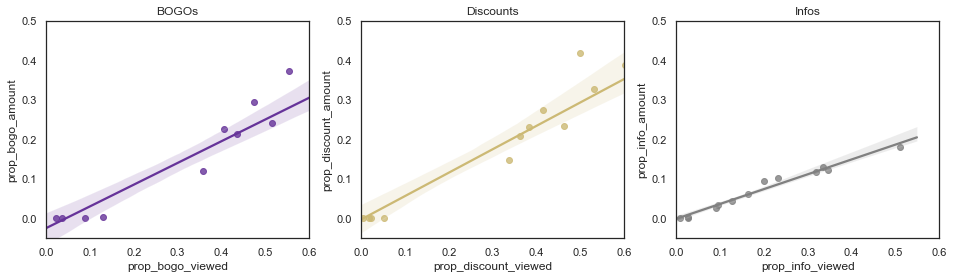

In [54]:
"""display correlations for view_prop to prop_amount of different offer types"""
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.regplot(x='prop_bogo_viewed', y='prop_bogo_amount', data=clusters_mean, color=color)
plt.ylim(-0.05, 0.5)
plt.xlim(0, 0.6)
plt.title("BOGOs", size=12)
plt.subplot(1,3,2)
sns.regplot(x='prop_discount_viewed', y='prop_discount_amount', data=clusters_mean, color='y')
plt.ylim(-0.05, 0.5)
plt.xlim(0, 0.6)
plt.title("Discounts", size=12)
plt.subplot(1,3,3)
sns.regplot(x='prop_info_viewed', y='prop_info_amount', data=clusters_mean, color='grey')
plt.title("Infos", size=12)
plt.ylim(-0.05, 0.5)
plt.xlim(0, 0.6);

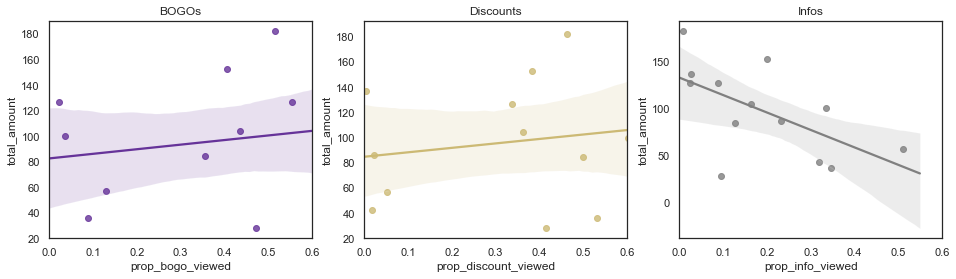

In [60]:
"""display correlations for view_prop to prop_amount of different offer types"""
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.regplot(x='prop_bogo_viewed', y='total_amount', data=clusters_mean, color=color)
# plt.ylim(-0.05, 0.5)
plt.xlim(0, 0.6)
plt.title("BOGOs", size=12)
plt.subplot(1,3,2)
sns.regplot(x='prop_discount_viewed', y='total_amount', data=clusters_mean, color='y')
# plt.ylim(-0.05, 0.5)
plt.xlim(0, 0.6)
plt.title("Discounts", size=12)
plt.subplot(1,3,3)
sns.regplot(x='prop_info_viewed', y='total_amount', data=clusters_mean, color='grey')
plt.title("Infos", size=12)
# plt.ylim(-0.05, 0.5)
plt.xlim(0, 0.6);

---

## Explore Demographic Features for Different Segments

#### 5 vs 12

Segments 5 and 12 are the most interesting for a direct comparision. In Segment 5 we have above average spenders who react on BOGOs but absolutely not on discounts. In Segment 12 we have people spending somewhat below average, who react on discounts but absolutely not on BOGOs.

In [62]:
def plot_cluster_demographics(df, cols, figsize=(16,12)):
    """Visually compares features of up to 3 segments. Outputs histograms
    for all numerical features and a countplot for genders."""
    clusters = list(df['cluster'].unique())
    colors = [color, 'yellow', 'grey']
    leg = zip(clusters, colors)
    for i in leg:
        print(i)
        
    plt.figure(figsize=(16,16))
    for pos, col in enumerate(cols):
        pos +=1
        plt.subplot((len(cols)/2) + 1, 2 , pos)
        if col != 'gender':
            for p, cluster in enumerate(clusters):
                sns.distplot(df.loc[df['cluster'] == clusters[p]][col], color=colors[p])
        else:
            sns.countplot(x='cluster', hue='gender', data=df, palette=colors);

In [63]:
"""create dataframe containing segments of interst only, drop NaN"""

seg_5_12 = profile_clusters.copy().loc[profile_clusters['cluster'].isin([5, 12])]
seg_5_12.dropna(how = 'any', inplace=True)

# check results
print("length: ", len(seg_5_12))
display(seg_5_12.groupby(['cluster']).mean())

length:  1947


,age,income,member_days,offer_received,offer_viewed,viewed_received,prop_bogo_viewed,prop_discount_viewed,prop_info_viewed,offer_completed,view_to_complete,prop_by_accident,total_trans,total_amount,total_reward,total_profit,prop_reward,total_mean_amount,prop_np_amount,prop_bogo_amount,prop_discount_amount,prop_info_amount,bogo_vtc,discount_vtc,bogo_completed,bogo_viewed,bogo_trans,bogo_amount,discount_completed,discount_viewed,discount_trans,discount_amount,info_viewed,info_trans,info_amount
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5.0,54.636010,67433.937824,-493.689119,4.660622,3.756477,0.814853,0.552979,0.333355,0.093048,2.638601,0.445639,0.256736,8.470207,137.733251,15.278497,122.454754,0.175753,18.299932,0.474163,0.353493,0.144039,0.028305,0.720984,0.052461,1.388601,2.089378,2.645078,41.329788,0.053109,1.183938,1.752591,20.972563,0.401554,0.393782,4.838439
12.0,53.411915,62271.489362,-542.074043,4.708936,3.685106,0.794099,0.355702,0.500468,0.125532,2.213617,0.466199,0.163943,9.406809,96.264323,7.722553,88.541770,0.111472,12.815509,0.464565,0.106284,0.383561,0.045590,0.005106,0.827404,0.005957,1.268085,1.651915,7.640430,1.419574,1.846809,3.075745,31.462857,0.502128,0.611915,5.325990


No handles with labels found to put in legend.


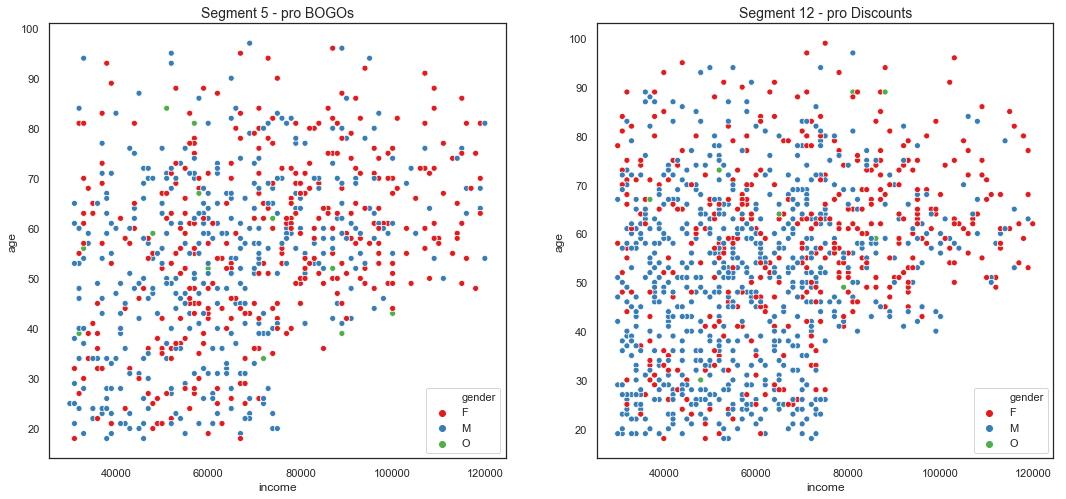

In [70]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
sns.scatterplot(x='income', y='age', hue='gender', data=seg_5_12.loc[seg_5_12['cluster'] == 5], palette='Set1')
plt.title("Segment 5 - pro BOGOs", size=14)
plt.subplot(1,2,2)
plt.legend(loc='lower right')
sns.scatterplot(x='income', y='age', hue='gender', data=seg_5_12.loc[seg_5_12['cluster'] == 12], palette='Set1')
plt.title("Segment 12 - pro Discounts", size=14)
plt.legend(loc='lower right');

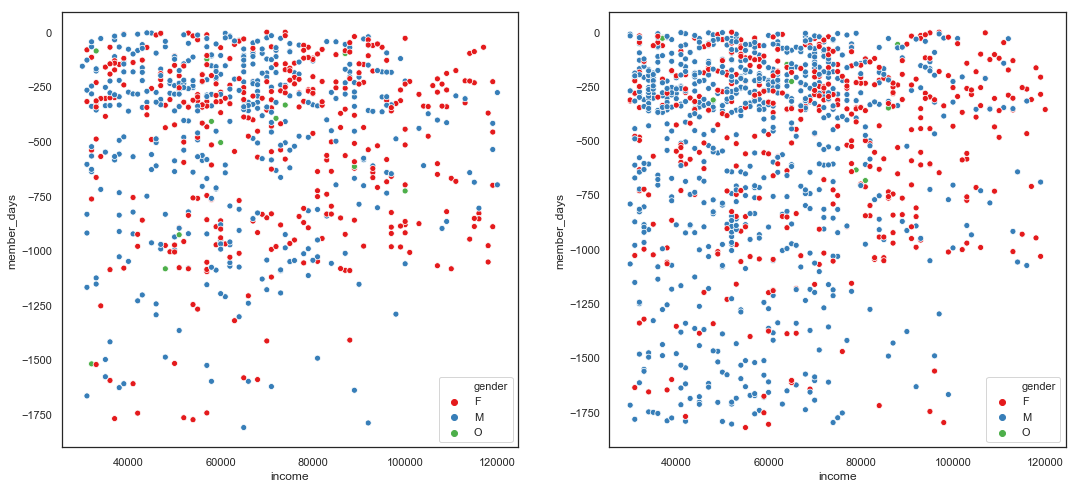

In [12]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
sns.scatterplot(x='income', y='member_days', hue='gender', data=seg_5_12.loc[seg_5_12['cluster'] == 5], palette='Set1')
plt.subplot(1,2,2)
sns.scatterplot(x='income', y='member_days', hue='gender', data=seg_5_12.loc[seg_5_12['cluster'] == 12], palette='Set1')

(12.0, 'rebeccapurple')
(5.0, 'yellow')


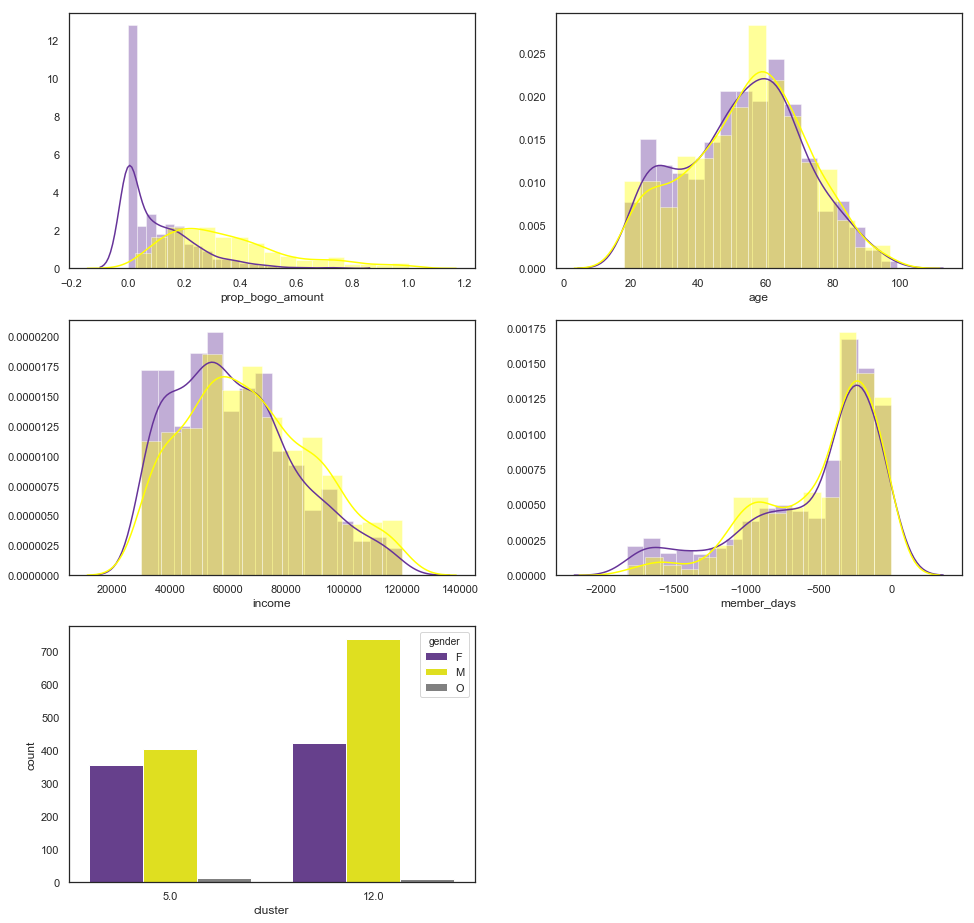

In [72]:
cols = ['prop_bogo_amount', 'age', 'income', 'member_days', 'gender']
plot_cluster_demographics(seg_5_12, cols=cols)

### 1 vs 9

If we'd assume that both segments have the same customers, the strategy for 1 works somewhat better, no info in the mix. Info doesn't seem to pay out.

In [38]:
"""create dataframe containing segments of interst only, drop NaN"""

seg_1_9 = profile_clusters.copy().loc[profile_clusters['cluster'].isin([1, 9])]
seg_1_9.dropna(how = 'any', inplace=True)

# check results
print("length: ", len(seg_1_9))
display(seg_1_9.groupby(['cluster']).mean())

length:  4835


,age,income,member_days,offer_received,offer_viewed,viewed_received,prop_bogo_viewed,prop_discount_viewed,prop_info_viewed,offer_completed,view_to_complete,prop_by_accident,total_trans,total_amount,total_reward,total_profit,prop_reward,total_mean_amount,prop_np_amount,prop_bogo_amount,prop_discount_amount,prop_info_amount,bogo_vtc,discount_vtc,bogo_completed,bogo_viewed,bogo_trans,bogo_amount,discount_completed,discount_viewed,discount_trans,discount_amount,info_viewed,info_trans,info_amount
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.0,56.596161,70713.670192,-613.652566,4.636506,3.817078,0.833431,0.514343,0.463161,0.008826,3.841363,0.820479,0.175767,10.426949,185.635511,19.484136,166.151375,0.141792,19.731554,0.530219,0.238373,0.230976,0.000432,0.819441,0.884978,1.506855,1.966706,2.389738,40.547395,1.478653,1.754015,2.342342,38.600670,0.042695,0.009009,0.096130
9.0,54.218668,65587.642419,-620.938650,4.860210,4.195881,0.866813,0.402644,0.382318,0.205010,2.974145,0.745486,0.126892,11.001753,157.426674,14.121385,143.305289,0.118532,16.235918,0.458013,0.220715,0.224364,0.096908,0.646801,0.905127,0.986854,1.659947,2.691499,26.064963,1.373795,1.581069,2.408414,31.893937,0.911919,1.076249,17.527297


(9.0, 'rebeccapurple')
(1.0, 'yellow')


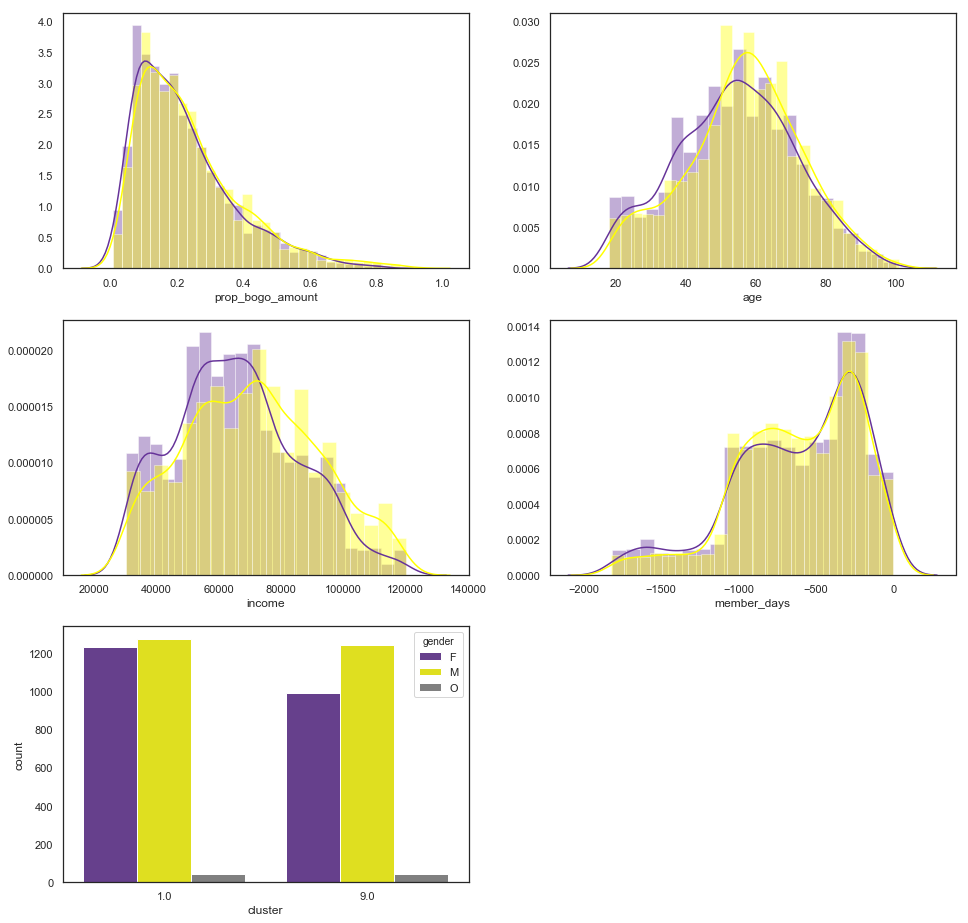

In [60]:
# create plots
plot_cluster_demographics(seg_1_9, cols=cols)

### 3 vs 6

BOGO heavy segments, 3 worked better, we should see the same pattern as before.

In [61]:
"""create dataframe containing segments of interst only, drop NaN"""

seg_3_6 = profile_clusters.copy().loc[profile_clusters['cluster'].isin([3, 6])]
seg_3_6.dropna(how = 'any', inplace=True)

# check results
print("length: ", len(seg_3_6))
display(seg_3_6.groupby(['cluster']).mean())

length:  2589


,age,income,member_days,offer_received,offer_viewed,viewed_received,prop_bogo_viewed,prop_discount_viewed,prop_info_viewed,offer_completed,view_to_complete,prop_by_accident,total_trans,total_amount,total_reward,total_profit,prop_reward,total_mean_amount,prop_np_amount,prop_bogo_amount,prop_discount_amount,prop_info_amount,bogo_vtc,discount_vtc,bogo_completed,bogo_viewed,bogo_trans,bogo_amount,discount_completed,discount_viewed,discount_trans,discount_amount,info_viewed,info_trans,info_amount
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3.0,54.833792,69915.518825,-602.915519,4.166208,2.710744,0.666850,0.923401,0.004178,0.027365,2.700643,0.742975,0.223676,8.751148,141.145133,18.157943,122.98719,0.176722,18.501318,0.592864,0.405025,0.000000,0.002111,0.746036,0.0,1.727273,2.466483,3.34068,49.765009,0.0,0.019284,0.000000,0.000000,0.102847,0.042241,0.505046
6.0,53.426000,62488.000000,-534.728667,4.372000,3.060667,0.709378,0.701067,0.020644,0.248333,1.482000,0.472667,0.126222,7.890000,94.777747,9.758667,85.01908,0.106378,12.680298,0.500690,0.389299,0.000033,0.109978,0.492622,0.0,0.922667,2.022000,2.98800,25.982383,0.0,0.084667,0.002667,0.001363,0.862000,1.011333,15.042713


(3.0, 'rebeccapurple')
(6.0, 'yellow')


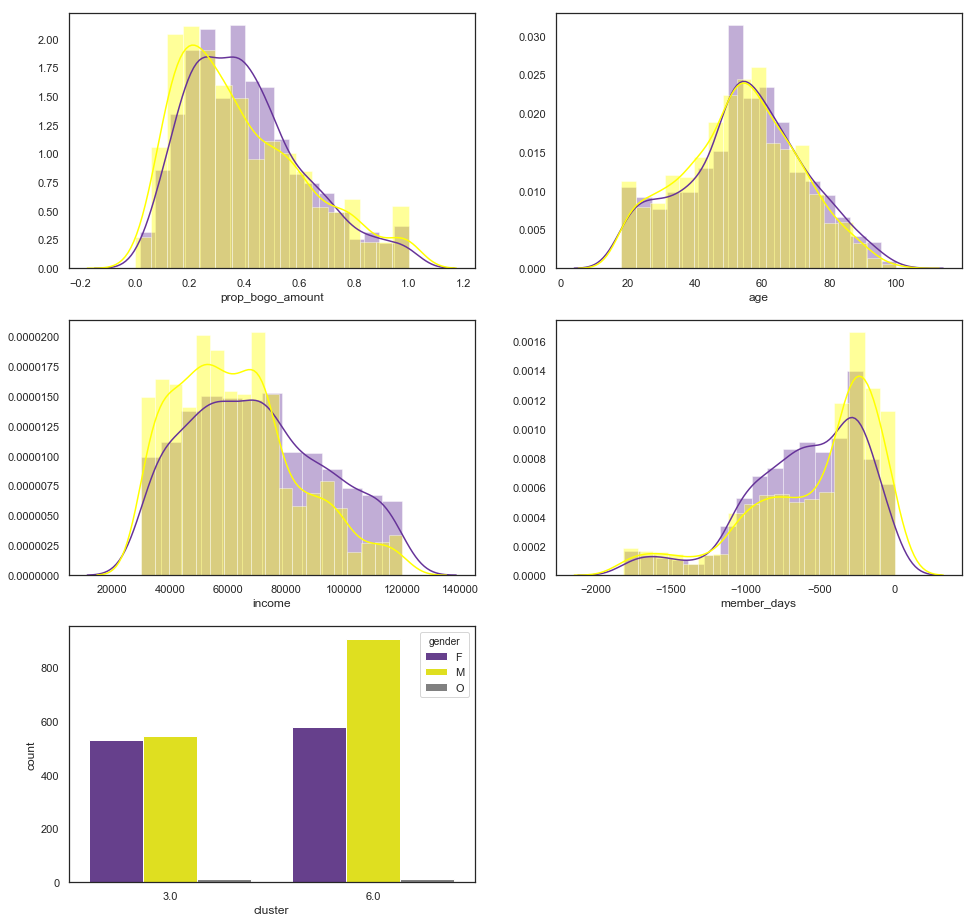

In [64]:
# create plots
plot_cluster_demographics(seg_3_6, cols=cols)

### 4 vs 8

DISCOUNT heavy segments, 4 worked slightly better, should be quite similar to segments 1 or 12

In [65]:
"""create dataframe containing segments of interst only, drop NaN"""

seg_4_8 = profile_clusters.copy().loc[profile_clusters['cluster'].isin([4, 8])]
seg_4_8.dropna(how = 'any', inplace=True)

# check results
print("length: ", len(seg_4_8))
display(seg_4_8.groupby(['cluster']).mean())

length:  2060


,age,income,member_days,offer_received,offer_viewed,viewed_received,prop_bogo_viewed,prop_discount_viewed,prop_info_viewed,offer_completed,view_to_complete,prop_by_accident,total_trans,total_amount,total_reward,total_profit,prop_reward,total_mean_amount,prop_np_amount,prop_bogo_amount,prop_discount_amount,prop_info_amount,bogo_vtc,discount_vtc,bogo_completed,bogo_viewed,bogo_trans,bogo_amount,discount_completed,discount_viewed,discount_trans,discount_amount,info_viewed,info_trans,info_amount
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4.0,55.791710,68765.803109,-582.469430,4.071503,2.573057,0.645164,0.020069,0.904059,0.026304,2.587565,0.802694,0.197323,8.688083,133.229212,8.06943,125.159782,0.094258,17.432582,0.559530,0.000042,0.436674,0.003753,0.0,0.823489,0.0,0.086010,0.004145,0.006632,1.746114,2.247668,3.253886,52.589347,0.108808,0.055959,0.660902
8.0,53.959817,65776.255708,-522.230137,4.336073,3.241096,0.759178,0.035708,0.589148,0.350441,1.789954,0.680304,0.121370,7.914155,109.403068,5.49589,103.907178,0.068779,15.024566,0.502755,0.000175,0.357849,0.139221,0.0,0.722618,0.0,0.150685,0.008219,0.006338,1.248402,1.825571,2.479452,28.172505,1.181735,1.321461,18.605741


(4.0, 'rebeccapurple')
(8.0, 'yellow')


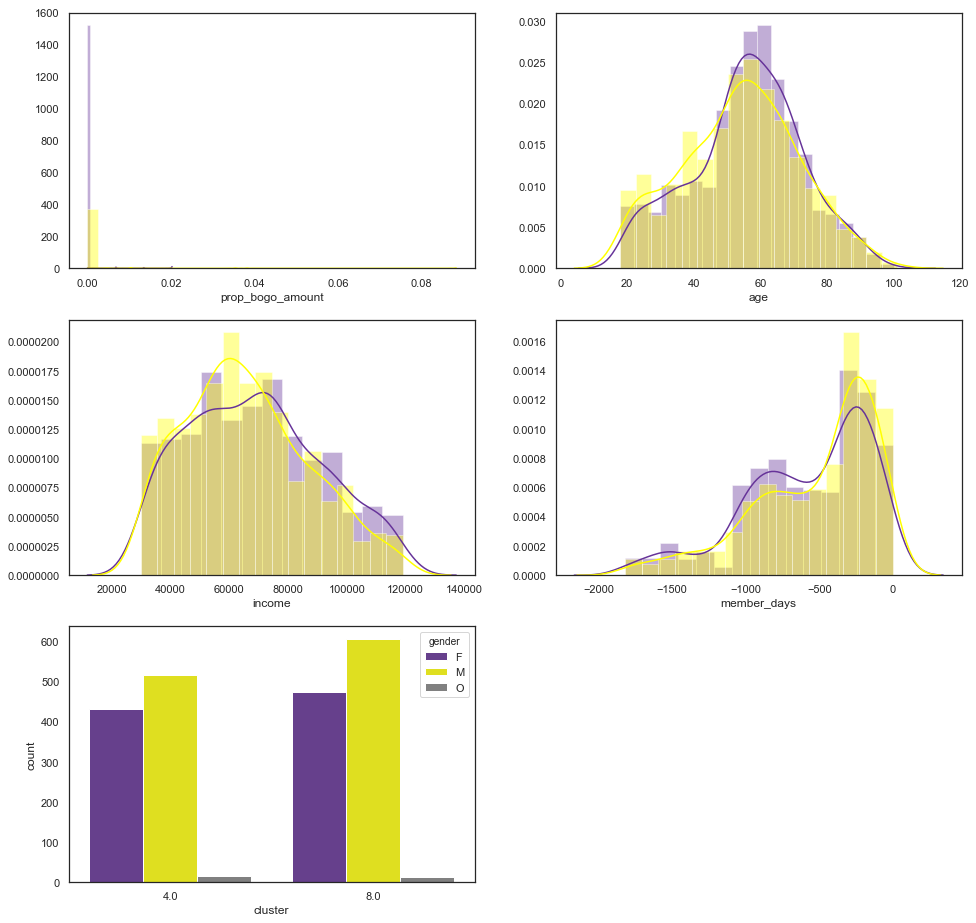

In [66]:
# create plots
plot_cluster_demographics(seg_4_8, cols=cols)

### 11 vs 2 vs 10

LOW turnover segments: 10 no reaction to any type, 11 no reaction to BOGOs, 2 no reaction to discounts

In [68]:
"""create dataframe containing segments of interst only, drop NaN"""

seg_2_10_11 = profile_clusters.copy().loc[profile_clusters['cluster'].isin([2, 10, 11])]
seg_2_10_11.dropna(how = 'any', inplace=True)

# check results
print("length: ", len(seg_2_10_11))
display(seg_2_10_11.groupby(['cluster']).mean())

length:  2132


,age,income,member_days,offer_received,offer_viewed,viewed_received,prop_bogo_viewed,prop_discount_viewed,prop_info_viewed,offer_completed,view_to_complete,prop_by_accident,total_trans,total_amount,total_reward,total_profit,prop_reward,total_mean_amount,prop_np_amount,prop_bogo_amount,prop_discount_amount,prop_info_amount,bogo_vtc,discount_vtc,bogo_completed,bogo_viewed,bogo_trans,bogo_amount,discount_completed,discount_viewed,discount_trans,discount_amount,info_viewed,info_trans,info_amount
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2.0,51.937644,58655.889145,-301.242494,4.387991,2.965358,0.690339,0.078099,0.529061,0.356236,0.503464,0.005004,0.113626,4.836028,48.013349,1.993072,46.020277,0.035572,10.605638,0.584687,0.001920,0.289580,0.123813,0.000000,0.010393,0.000000,0.304850,0.034642,0.031062,0.011547,1.461894,1.577367,9.108383,1.092379,0.792148,6.795058
10.0,50.006316,54002.105263,-290.890526,4.650526,3.310526,0.726018,0.472614,0.418193,0.091579,0.418947,0.020351,0.081789,6.036842,35.648947,1.828421,33.820526,0.034176,6.621860,0.438084,0.274506,0.254709,0.032701,0.021053,0.025088,0.025263,1.548421,2.002105,6.960079,0.027368,1.334737,1.856842,6.137728,0.362105,0.314737,3.021340
11.0,51.942590,57189.586115,-428.016021,4.283044,2.750334,0.655563,0.626057,0.012016,0.325701,0.570093,0.009123,0.134735,6.704940,51.186435,3.062750,48.123685,0.053401,9.147947,0.618390,0.263007,0.000082,0.118521,0.009791,0.000000,0.012016,1.628838,2.379172,8.486302,0.000000,0.046729,0.004005,0.000794,0.966622,1.050734,8.149005


(11.0, 'rebeccapurple')
(2.0, 'yellow')
(10.0, 'grey')


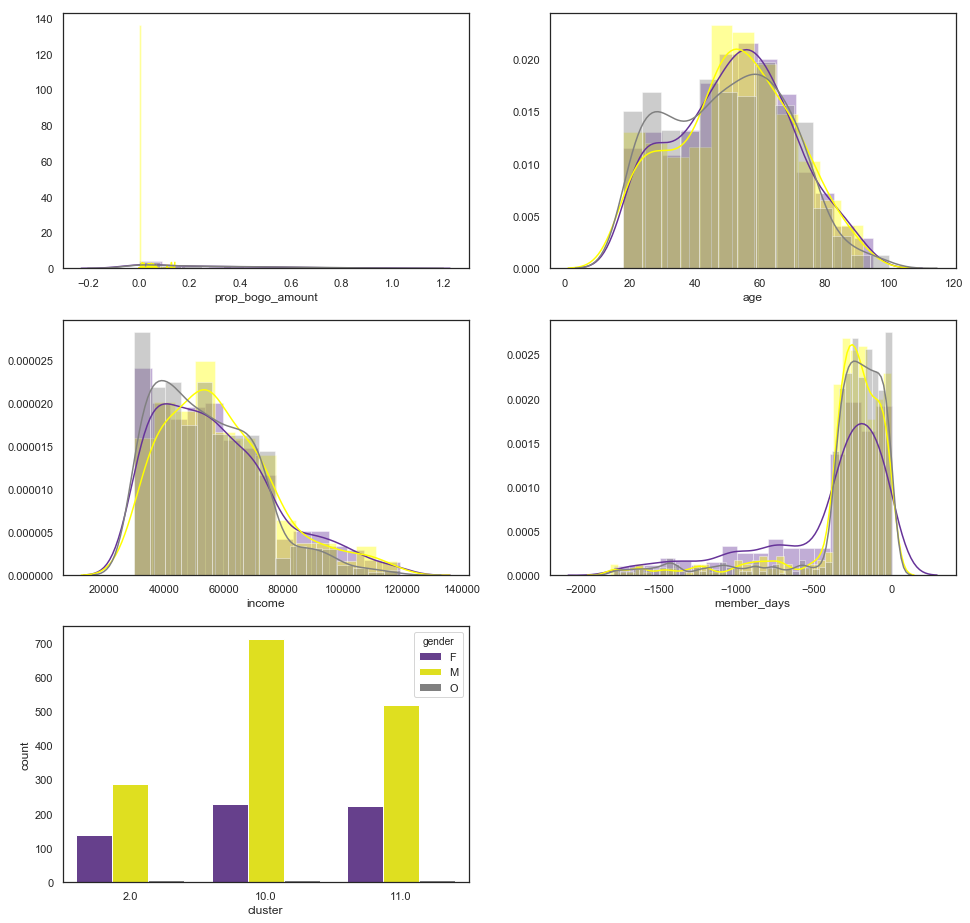

In [69]:
# create plots
plot_cluster_demographics(seg_2_10_11, cols=cols)

---

In [ ]:
"""show boxplot per segment - did not work, had to give up"""
# https://stackoverflow.com/questions/47136855/seaborn-boxplot-with-2-y-axes

# box_df = profile_clusters[['cluster', 'bogo_vtc', 'discount_vtc', 'total_amount']]
# fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 24))

# for pos, cluster in enumerate(list(box_df['cluster'].unique())):
#     box_df = box_df.loc[box_df['cluster'] == cluster]
#     pos =+1
#     plt.subplot(4, 3, pos)    
# #     fig, ax1  = plt.subplots(figsize=(7.8, 5.51))
#     props = dict(widths=0.7, patch_artist=True, medianprops=dict(color="gold"))
#     box1=ax1.boxplot(box_df[['bogo_vtc', 'discount_vtc']].values, positions=[0, 1], **props)
#     ax2 = ax1.twinx()
#     box2=ax2.boxplot(box_df['total_amount'].values, positions=[2], **props)

#     ax1.set_xlim(-0.5,2.5)
#     ax1.set_ylim(-0.05,1)
#     ax1.set_xticks(range(len(box_df.columns)))
#     ax1.set_xticklabels(box_df.columns)

#     for b in box1["boxes"]+box2["boxes"]:
#         b.set_facecolor(next(ax1._get_lines.prop_cycler)["color"])
#         plt.show();

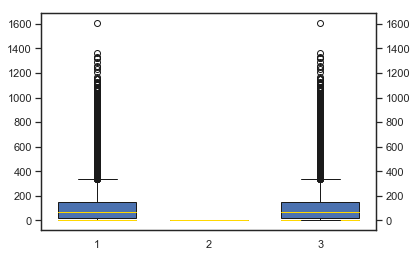

In [106]:
box_df = profile_clusters[['cluster', 'bogo_vtc', 'discount_vtc', 'total_amount']]
props = dict(widths=0.7, patch_artist=True, medianprops=dict(color="gold"))

box1 = plt.boxplot(box_df[['bogo_vtc', 'discount_vtc', 'total_amount']].values, positions=(3,2,1), **props)
plt.twinx()
box2 = plt.boxplot(box_df[['total_amount', 'bogo_vtc', 'discount_vtc',]].values, positions=(3,2,1), **props)
# box2 = plt.boxplot(box_df['total_amount'].values, positions=([0]), **props)